# Re-program by Dipankar Bhowmik
## Models
### Date: 17-09-2020

In [1]:
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm # Decorate an iterable object, returning an iterator which acts exactly like the original iterable, 
                      # but prints a dynamically updating progressbar every time a value is requested
import re # used to work with Regular Expressions.
import matplotlib.pyplot as plt # Python 2D plotting library
import seaborn as sns #Seaborn is a library for making statistical graphics in Python
from pandas.plotting import table # Basic Plotting
from sklearn.feature_extraction.text import CountVectorizer # Convert a collection of text to matrix of token counts
from sklearn.feature_extraction.text import TfidfVectorizer # Convert a collection of raw to matrix of TF-IDF features
import time # provides various time-related functions
from datetime import timedelta #timedelta:- A duration expressing the difference between two date, time, or datetime.
from google.colab import drive # Downloading Datasets into Google Drive via Google Colab
from collections import Counter # It allows you to count the items in an iterable list
from keras.preprocessing.sequence import pad_sequences 
#'pad_sequences'Takes in a sequence of data-points gathered at equal intervals, along with time series parameters
#such as stride, length of history, etc., to produce batches for training/validation
from keras.utils import to_categorical # Convert array of labeled data(from 0 to nb_classes-1) to one-hot vector.
from sklearn.preprocessing import LabelEncoder #Categorical values into numerical values, encode target values, i.e. y
import random # It implements pseudo-random number generators for various distributions

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import tensorflow as tf # Software library 
from tensorflow import keras # TensorFlow's high-level API for building and training deep learning models.
from tensorflow.keras.utils import plot_model # Converts a Keras model to dot format and save to a file
from tensorflow.keras import layers #  A layer encapsulates both a state (the layer's "weights"
# and a transformation from inputs to outputs.

In [3]:
# Restart runtime using 'Runtime' -> 'Restart runtime...'
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

2.3.0


In [4]:
#Functions to save objects for future usage and repossess
#stackoverflow.com/questions/1253528/is-there-an-easy-way-to-pickle-a-python-function-or-otherwise-serialize-its-cod
import pickle
def transmit(obj,filename):
    pickle.dump(obj,open(filename+".p","wb"), protocol=4)
def receive(filename):
    temp = pickle.load(open(filename+".p","rb"))
    return temp

In [5]:
drive.mount('/content/drive') # for mounting Google Drive files 

Mounted at /content/drive



### Loading the data

In [ ]:
# Reading the content of the folder Development by creating function 'read_all_shards'
# source: https://www.kaggle.com/drewbryant/starter-pfam-seed-random-split

def read_all_shards(partition='dev', data_dir='drive/My Drive/Colab Notebooks'):
    shards = []
    ## Returns a list containing the names of the entries in the directory given by path "data_dir".
    for fn in os.listdir(os.path.join(data_dir, partition)):
        ## join and open given path "data_dir" components intelligently.
        with open(os.path.join(data_dir, partition, fn)) as f: ## here f is a file handler
            ## Read and append every file with skipping "aligned_sequence" column
            shards.append(pd.read_csv(f, usecols = lambda column : column not in["aligned_sequence"]))
    return pd.concat(shards)

## Building the respective ('dev', 'test', 'train') the files
test = read_all_shards('test')
dev = read_all_shards('dev')
train = read_all_shards('train')

## Calcutlating the no. of sequence in each file.
partitions = {'test': test, 'dev': dev, 'train': train}
for name, df in partitions.items():
    print('Dataset partition "%s" has %d sequences' % (name, len(df)))

Dataset partition "test" has 126171 sequences
Dataset partition "dev" has 126171 sequences
Dataset partition "train" has 1086741 sequences


In [ ]:
transmit(train,"drive/My Drive/Colab Notebooks/train")
transmit(test,"drive/My Drive/Colab Notebooks/test")
transmit(dev,"drive/My Drive/Colab Notebooks/dev")

In [6]:
train = receive("drive/My Drive/Colab Notebooks/train")
test = receive("drive/My Drive/Colab Notebooks/test")
dev = receive("drive/My Drive/Colab Notebooks/dev")

# Prerequsite for modeling

### No. Unique classes

In [ ]:
## Concating three files
#https://stackoverflow.com/a/44338504

frames = [test, dev, train]
all_data = pd.concat(frames)

In [ ]:
transmit(all_data,'drive/My Drive/Colab Notebooks/all_data')

In [ ]:
# Unique classes
#https://stackoverflow.com/a/12323599
#https://stackoverflow.com/a/34272155

start_time = time.time()
print("Number of unique classes through development set: ", len(dev.drop_duplicates(subset=['family_accession'])))
print("Number of unique classes through test set: ", len(test.drop_duplicates(subset=['family_accession'])))
print("Number of unique classes through train set: ", len(train.drop_duplicates(subset=['family_accession'])))
print("Number of unique classes through all data set: ", len(all_data.drop_duplicates(subset=['family_accession'])))
print('\nElapsed time - '+str(timedelta(seconds=(time.time() - start_time))))

Number of unique classes through development set:  13071
Number of unique classes through test set:  13071
Number of unique classes through train set:  17929
Number of unique classes through all data set:  17929

Elapsed time - 0:00:00.340908


In [ ]:
dev.family_accession.describe()

count        126171
unique        13071
top       PF13649.6
freq            454
Name: family_accession, dtype: object

In [ ]:
train.family_accession.describe()

count       1086741
unique        17929
top       PF13649.6
freq           3637
Name: family_accession, dtype: object

In [ ]:
test.family_accession.describe()

count        126171
unique        13071
top       PF13649.6
freq            454
Name: family_accession, dtype: object

In [ ]:
all_data.family_accession.describe()

count       1339083
unique        17929
top       PF13649.6
freq           4545
Name: family_accession, dtype: object

### Calculating top 17k families contain large number of sequence

In [ ]:
all_data

,family_id,sequence_name,family_accession,sequence
0,GNAT_acetyltran,R6RQF6_9CLOT/17-251,PF12746.7,AFLFSGRREVMADACLQGMMGCVYGTAGGMDSAAAVLGDFCFLAGK...
1,MoaC,W5NKR5_LEPOC/505-640,PF01967.21,MVDVGGKPVSRRTAAASATVLLGEKAFWLVKENQLAKGDALAVAQI...
2,Methyltransf_25,C0QLU8_DESAH/50-147,PF13649.6,VLDVACGTCDVAMEARNQTGDAAFIIGTDFSPGMLTLGLQKLKKNR...
3,EMG1,T1G7Q2_HELRO/22-222,PF03587.14,VVLERASLESVKVGKEYQLLNCDRHKGIAKKFKRDISTCRPDITHQ...
4,Glyco_hydro_30C,C6VRM9_DYAFD/453-540,PF17189.4,GAVRVDVSGGLGTDAMVVSSYLNTDKSLVTVIVNADNQDRDISLAI...
...,...,...,...,...
13510,DUF4276,B1Y1D3_LEPCP/11-206,PF14103.6,VEEPSMEAFLHALLPRLMPARRTFEIHPFQGKDDLMAKLEARLRAY...
13511,Lipoprotein_3,Y645_MYCPN/25-108,PF00938.17,AATQVISSLSSAQKYFESSQGELNKKNVIKILKEGYESDANKAVHA...
13512,Ribosomal_S6,I4DCK0_DESAJ/3-92,PF01250.17,AYEILYIIRPDMDEEATNALVDRLSGLAASNGGQNVTVDKWGKRRL...
13513,Sterile,K7J1J9_NASVI/384-476,PF03015.19,LDYVPALVADLLAVLHGNAPDSWALLRESMGDMCRLHRFSSGNWRI...


In [ ]:
# top 17929 family
# https://stackoverflow.com/a/20511316
# https://www.geeksforgeeks.org/python-change-column-names-and-row-indexes-in-pandas-dataframe/
fam_counts = pd.DataFrame( Counter(all_data.family_accession).most_common(17928))
fam_counts.columns =['family_accession', 'frequency'] 

In [ ]:
fam_counts

,family_accession,frequency
0,PF13649.6,4545
1,PF00560.33,2407
2,PF13508.7,2199
3,PF06580.13,1921
4,PF02397.16,1908
...,...,...
17923,PF08077.11,1
17924,PF09460.10,1
17925,PF12941.7,1
17926,PF05750.11,1


In [ ]:
del fam_counts['frequency'] # deleting the frequency column

In [ ]:
fam_counts

,family_accession
0,PF13649.6
1,PF00560.33
2,PF13508.7
3,PF06580.13
4,PF02397.16
...,...
17923,PF08077.11
17924,PF09460.10
17925,PF12941.7
17926,PF05750.11


In [ ]:
# Top frequency contain  in families of train, test and dev
# https://stackoverflow.com/a/47640804

train_17k = fam_counts.merge(train, on="family_accession", how = 'inner')
test_17k = fam_counts.merge(test, on="family_accession", how = 'inner')
dev_17k = fam_counts.merge(dev, on="family_accession", how = 'inner')

In [ ]:
print('No. of rows are following respectively train_17k_class : %d, test_17k_class: %d, and dev_17k_class: %d' 
      %(len(train_17k),len(test_17k),len(dev_17k)))

No. of rows are following respectively train_17k_class : 1086740, test_17k_class: 126171, and dev_17k_class: 126171


In [ ]:
dev_17k.head(5)

,family_accession,family_id,sequence_name,sequence
0,PF13649.6,Methyltransf_25,D1C4C3_SPHTD/46-139,VLDLGCANGATSRALADLGARVTGVDVSARLIELARQREAARPRGV...
1,PF13649.6,Methyltransf_25,B0SPK0_LEPBP/31-121,ALDAGAGPGVLTSFLMKKNPNLKWMACDISEDMVQYCKLVYPKVDW...
2,PF13649.6,Methyltransf_25,G8TIH4_NIAKG/40-134,VLDIACGEGYGTALIGKYAQKAVGVDIDDTCIQWGTQHYAAANNKL...
3,PF13649.6,Methyltransf_25,B8J3T0_DESDA/75-167,ILSVGCGSGFVEHCLLQMRPNIQMHCNDSSDSPLRWIAQSLPEEQL...
4,PF13649.6,Methyltransf_25,R5N3A4_9FIRM/52-142,VLEIGVGTGRLAVRVAPLCDKFCGIDISPKTVNKAKENLVQYSNVN...


In [ ]:
# Below will provide numeric form to family_accession
# https://stackoverflow.com/a/49574839
fam_counts['fam_no'] = np.arange(len(fam_counts))
fam_counts

,family_accession,fam_no
0,PF13649.6,0
1,PF00560.33,1
2,PF13508.7,2
3,PF06580.13,3
4,PF02397.16,4
...,...,...
17923,PF08077.11,17923
17924,PF09460.10,17924
17925,PF12941.7,17925
17926,PF05750.11,17926


In [ ]:
# python pandas dataframe to dictionary
# https://stackoverflow.com/a/18695700
fam_counts_dic = fam_counts.set_index('family_accession')['fam_no'].to_dict()

In [ ]:
fam_counts_dic

{'PF13649.6': 0,
 'PF00560.33': 1,
 'PF13508.7': 2,
 'PF06580.13': 3,
 'PF02397.16': 4,
 'PF00677.17': 5,
 'PF01035.20': 6,
 'PF02417.15': 7,
 'PF13472.6': 8,
 'PF00684.19': 9,
 'PF02881.19': 10,
 'PF00400.32': 11,
 'PF02729.21': 12,
 'PF00391.23': 13,
 'PF02885.17': 14,
 'PF00763.23': 15,
 'PF01255.19': 16,
 'PF00126.27': 17,
 'PF02545.14': 18,
 'PF01368.20': 19,
 'PF03453.17': 20,
 'PF00586.24': 21,
 'PF01799.20': 22,
 'PF01725.16': 23,
 'PF01523.16': 24,
 'PF03484.15': 25,
 'PF05192.18': 26,
 'PF01715.17': 27,
 'PF01687.17': 28,
 'PF01556.18': 29,
 'PF02843.16': 30,
 'PF00381.19': 31,
 'PF03462.18': 32,
 'PF13692.6': 33,
 'PF02787.19': 34,
 'PF13976.6': 35,
 'PF00137.21': 36,
 'PF00842.21': 37,
 'PF10035.9': 38,
 'PF00023.30': 39,
 'PF13439.6': 40,
 'PF14748.6': 41,
 'PF00472.20': 42,
 'PF03458.13': 43,
 'PF01195.19': 44,
 'PF01769.16': 45,
 'PF10396.9': 46,
 'PF00231.19': 47,
 'PF13932.6': 48,
 'PF03948.14': 49,
 'PF04205.14': 50,
 'PF01040.18': 51,
 'PF01288.20': 52,
 'PF02844.15'

In [ ]:
dev_17k_num = dev_17k
test_17k_num = test_17k
train_17k_num = train_17k

In [ ]:
# Using dictionary to remap values in Pandas DataFrame columns
# https://www.geeksforgeeks.org/using-dictionary-to-remap-values-in-pandas-dataframe-columns/
test_17k_num = test_17k_num.replace({"family_accession": fam_counts_dic})
dev_17k_num = dev_17k_num.replace({"family_accession": fam_counts_dic})
train_17k_num = train_17k_num.replace({"family_accession": fam_counts_dic})

In [ ]:
transmit(train_17k_num,"drive/My Drive/Colab Notebooks/train_17k_num")
transmit(test_17k_num,"drive/My Drive/Colab Notebooks/test_17k_num")
transmit(dev_17k_num,"drive/My Drive/Colab Notebooks/dev_17k_num")

In [7]:
test_17k_num = receive("drive/My Drive/Colab Notebooks/test_17k_num")
dev_17k_num = receive("drive/My Drive/Colab Notebooks/dev_17k_num")
train_17k_num = receive("drive/My Drive/Colab Notebooks/train_17k_num")

In [8]:
dev_17k_num[2973:2980]

,family_accession,family_id,sequence_name,sequence
2973,15,THF_DHG_CYH,R6QT71_9FIRM/6-120,IDGKAISDQIKEEAALEAQKLQRQGITPCLAVVLVGNDPASMVYVN...
2974,15,THF_DHG_CYH,S9VZM3_SCHCR/15-123,VIYASRVAESFVEQLKELVKQFEPAPKLVGFLANTDPAARMYADWT...
2975,15,THF_DHG_CYH,A3U7Q6_CROAH/3-119,ILDGKATSEKIKLEITEEVNKMKANNEKVPHLAAIIVGNDGASLTY...
2976,15,THF_DHG_CYH,FOLD_PROMM/5-120,LDGKQLAAELEQRLQAEIAAGLVQAGRPPGLAVLRIGDDPASGVYV...
2977,16,Prenyltransf,C8WAK0_ATOPD/36-256,IMDGNGRWATARGLDRTEGHKAGVLSLREAVTTSVRLGLDVLSVYS...
2978,16,Prenyltransf,D9S3N2_THEOJ/24-244,IMDGNGRWAQKRGLPRIAGHWAGAENLRNIVEFCSELNIKVLTVFA...
2979,16,Prenyltransf,R5Q8N4_9PROT/14-234,IMDGNGRWAEKHGLPRTFGHRKGVKAAETMVESCLEAGISYLTLFC...


In [9]:
all_data = receive('drive/My Drive/Colab Notebooks/all_data')

In [ ]:
# Below code will consider the top 1000 family
# https://stackoverflow.com/a/20511316
# https://www.geeksforgeeks.org/python-change-column-names-and-row-indexes-in-pandas-dataframe/

fam_counts_1k = pd.DataFrame( Counter(all_data.family_accession).most_common(1000))
fam_counts_1k.columns =['family_accession', 'frequency'] 

print(fam_counts_1k)
del fam_counts_1k['frequency']


# Top frequency of families in train, test and dev
# https://stackoverflow.com/a/47640804

train_1k = fam_counts_1k.merge(train, on="family_accession", how = 'inner')
test_1k = fam_counts_1k.merge(test, on="family_accession", how = 'inner')
dev_1k = fam_counts_1k.merge(dev, on="family_accession", how = 'inner')

# Below will provide numeric no to family_accession
# https://stackoverflow.com/a/49574839
fam_counts_1k['fam_no'] = np.arange(len(fam_counts_1k))

# python pandas dataframe to dictionary
# https://stackoverflow.com/a/18695700

fam_counts_1k_dic = fam_counts_1k.set_index('family_accession')['fam_no'].to_dict()

dev_1k_num = dev_1k
test_1k_num = test_1k
train_1k_num = train_1k

# Using dictionary to remap values in Pandas DataFrame columns
# https://www.geeksforgeeks.org/using-dictionary-to-remap-values-in-pandas-dataframe-columns/
test_1k_num = test_1k_num.replace({"family_accession": fam_counts_1k_dic})
dev_1k_num = dev_1k_num.replace({"family_accession": fam_counts_1k_dic})
train_1k_num = train_1k_num.replace({"family_accession": fam_counts_1k_dic})

    family_accession  frequency
0          PF13649.6       4545
1         PF00560.33       2407
2          PF13508.7       2199
3         PF06580.13       1921
4         PF02397.16       1908
..               ...        ...
995       PF04961.12        284
996        PF16875.5        284
997       PF00346.19        284
998        PF10143.9        284
999       PF00484.19        284

[1000 rows x 2 columns]


In [ ]:
transmit(train_1k_num,"drive/My Drive/Colab Notebooks/train_1k_num")
transmit(test_1k_num,"drive/My Drive/Colab Notebooks/test_1k_num")
transmit(dev_1k_num,"drive/My Drive/Colab Notebooks/dev_1k_num")

In [46]:
fam_counts_1k_dic

{'PF13649.6': 0,
 'PF00560.33': 1,
 'PF13508.7': 2,
 'PF06580.13': 3,
 'PF02397.16': 4,
 'PF00677.17': 5,
 'PF01035.20': 6,
 'PF02417.15': 7,
 'PF13472.6': 8,
 'PF00684.19': 9,
 'PF02881.19': 10,
 'PF00400.32': 11,
 'PF02729.21': 12,
 'PF00391.23': 13,
 'PF02885.17': 14,
 'PF00763.23': 15,
 'PF01255.19': 16,
 'PF00126.27': 17,
 'PF02545.14': 18,
 'PF01368.20': 19,
 'PF03453.17': 20,
 'PF00586.24': 21,
 'PF01799.20': 22,
 'PF01725.16': 23,
 'PF01523.16': 24,
 'PF03484.15': 25,
 'PF05192.18': 26,
 'PF01715.17': 27,
 'PF01687.17': 28,
 'PF01556.18': 29,
 'PF02843.16': 30,
 'PF00381.19': 31,
 'PF03462.18': 32,
 'PF13692.6': 33,
 'PF02787.19': 34,
 'PF13976.6': 35,
 'PF00137.21': 36,
 'PF00842.21': 37,
 'PF10035.9': 38,
 'PF00023.30': 39,
 'PF13439.6': 40,
 'PF14748.6': 41,
 'PF00472.20': 42,
 'PF03458.13': 43,
 'PF01195.19': 44,
 'PF01769.16': 45,
 'PF10396.9': 46,
 'PF00231.19': 47,
 'PF13932.6': 48,
 'PF03948.14': 49,
 'PF04205.14': 50,
 'PF01040.18': 51,
 'PF01288.20': 52,
 'PF02844.15'

In [47]:
transmit(fam_counts_1k_dic,"drive/My Drive/Colab Notebooks/fam_counts_1k_dic")

In [11]:
dev_1k_num[2973:2980]

,family_accession,family_id,sequence_name,sequence
2973,15,THF_DHG_CYH,R6QT71_9FIRM/6-120,IDGKAISDQIKEEAALEAQKLQRQGITPCLAVVLVGNDPASMVYVN...
2974,15,THF_DHG_CYH,S9VZM3_SCHCR/15-123,VIYASRVAESFVEQLKELVKQFEPAPKLVGFLANTDPAARMYADWT...
2975,15,THF_DHG_CYH,A3U7Q6_CROAH/3-119,ILDGKATSEKIKLEITEEVNKMKANNEKVPHLAAIIVGNDGASLTY...
2976,15,THF_DHG_CYH,FOLD_PROMM/5-120,LDGKQLAAELEQRLQAEIAAGLVQAGRPPGLAVLRIGDDPASGVYV...
2977,16,Prenyltransf,C8WAK0_ATOPD/36-256,IMDGNGRWATARGLDRTEGHKAGVLSLREAVTTSVRLGLDVLSVYS...
2978,16,Prenyltransf,D9S3N2_THEOJ/24-244,IMDGNGRWAQKRGLPRIAGHWAGAENLRNIVEFCSELNIKVLTVFA...
2979,16,Prenyltransf,R5Q8N4_9PROT/14-234,IMDGNGRWAEKHGLPRTFGHRKGVKAAETMVESCLEAGISYLTLFC...


In [10]:
train_1k_num = receive("drive/My Drive/Colab Notebooks/train_1k_num")
test_1k_num = receive("drive/My Drive/Colab Notebooks/test_1k_num")
dev_1k_num = receive('drive/My Drive/Colab Notebooks/dev_1k_num')

## Tokenizer

In [14]:
# Below code will splite alphabet into tokens
# https://machinelearningmastery.com/prepare-text-data-deep-learning-keras/
token_vec = tf.keras.preprocessing.text.Tokenizer(char_level=True)
token_vec.fit_on_texts(train_1k_num['sequence'].values)

In [15]:
print("length of the vocab ",len(token_vec.word_index), token_vec.word_index.keys())

length of the vocab  24 dict_keys(['l', 'a', 'g', 'v', 'i', 'e', 's', 'r', 'd', 't', 'k', 'p', 'f', 'n', 'q', 'y', 'm', 'h', 'c', 'w', 'x', 'u', 'b', 'o'])


In [ ]:
# Taking sample from train
train_1k_num.values[10000]

array([4, 'Bac_transf', 'U5MSR3_CLOSA/26-214',
       'KRFIDIICSLIALIVLMPILIIVAILIKIESSGPIIFCQNRVGKGGAIFKIYKFRSMVTNAEALKEHLAHENERSGPMFKIKNDPRVTKVGRIIRRTSIDELPQLLNILKGDMSIVGPRPSLPKEVEQFEEWMLKRLTVKPGLTCYWQVSGRNDIEFNEWMELDIKYVNERNVGIDILLILKTFSVLFG'],
      dtype=object)

In [54]:
# Convert the sequence into vector 
token_train_one_sample_1k=token_vec.texts_to_sequences(["KRFIDIICSLIALIVLMPILIIVAILIKIESSGPIIFCQNRVGKGGAIFKIYKFRSMVTNAEALKEHLAHENERSGPMFKIKNDPRVTKVGRIIRRTSIDELPQLLNILKGDMSIVGPRPSLPKEVEQFEEWMLKRLTVKPGLTCYWQVSGRNDIEFNEWMELDIKYVNERNVGIDILLILKTFSVLFG'])
print(token_train_one_sample_1k)

[[11, 8, 13, 5, 9, 5, 5, 19, 7, 1, 5, 2, 1, 5, 4, 1, 17, 12, 5, 1, 5, 5, 4, 2, 5, 1, 5, 11, 5, 6, 7, 7, 3, 12, 5, 5, 13, 19, 15, 14, 8, 4, 3, 11, 3, 3, 2, 5, 13, 11, 5, 16, 11, 13, 8, 7, 17, 4, 10, 14, 2, 6, 2, 1, 11, 6, 18, 1, 2, 18, 6, 14, 6, 8, 7, 3, 12, 17, 13, 11, 5, 11, 14, 9, 12, 8, 4, 10, 11, 4, 3, 8, 5, 5, 8, 8, 10, 7, 5, 9, 6, 1, 12, 15, 1, 1, 14, 5, 1, 11, 3, 9, 17, 7, 5, 4, 3, 12, 8, 12, 7, 1, 12, 11, 6, 4, 6, 15, 13, 6, 6, 20, 17, 1, 11, 8, 1, 10, 4, 11, 12, 3, 1, 10, 19, 16, 20, 15, 4, 7, 3, 8, 14, 9, 5, 6, 13, 14, 6, 20, 17, 6, 1, 9, 5, 11, 16, 4, 14, 6, 8, 14, 4, 3, 5, 9, 5, 1, 1, 5, 1, 11, 10, 13, 7, 4, 1, 13, 3]]


In [17]:
# Save the token for further prediction testing
transmit(token_vec,"drive/My Drive/Colab Notebooks/token_vec")

### Fixing the length for padding

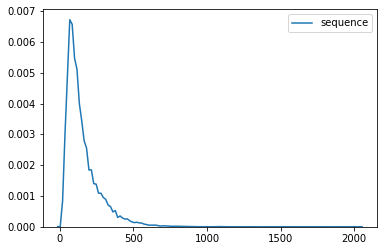

0 4.0
5 40.0
10 52.0
15 62.0
20 69.0
25 76.0
30 84.0
35 91.0
40 100.0
45 109.0
50 119.0
55 129.0
60 142.0
65 157.0
70 174.0
75 195.0
80 223.0
85 259.0
90 308.0
95 385.0
100 2037.0
95 385.0
96 416.0
97 452.0
98 502.0
99 584.0
100 2037.0


In [ ]:
# https://www.journaldev.com/40204/seaborn-kdeplot
seq_lens = all_data['sequence'].str.len()
sns.kdeplot(seq_lens)
plt.show()
for i in range(0,101, 5):
  print(i,np.percentile(seq_lens,i))
for i in range(95,101):
  print(i,np.percentile(seq_lens,i))

So 450 to 550 length (sequence) has been taken for padding

# Padding

In [21]:
# below code will put padding having maximum length 400
# https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/
# https://keras.io/preprocessing/sequence/

def padding(pad_seq):
  pad_data = tf.keras.preprocessing.sequence.pad_sequences(pad_seq, maxlen=400, dtype='int32', padding='post',
                                                           truncating='post', value=0.0)
  return pad_data

In [22]:
# below code will put padding havind maximum length 550
def padding2(pad_seq):
  pad_data = tf.keras.preprocessing.sequence.pad_sequences(pad_seq, maxlen=550, dtype='int32', padding='post', truncating='post', value=0.0)
  return pad_data

In [ ]:
transmit(dev_1k_num,"drive/My Drive/Colab Notebooks/dev_1k_num")

# Generator

In [ ]:
# Create data for training the encoder-decoder model. We will use fit_generator() as our data is too large to fit
#    into the memory with 400 padding
# The fit_generator() will accept a batch of data from the underlying function, generator() 
# https://www.jessicayung.com/using-generators-in-python-to-train-machine-learning-models/
# https://towardsdatascience.com/implementing-neural-machine-translation-using-keras-8312e4844eb8

def generator(samples_X,samples_y, batch_size):
  c = list(zip(samples_X,samples_y))                          # Joining sequence & class of protein forming a list
  random.shuffle(c)                                           # Reorganize the order of sequence paired class
  samples_X,samples_y = zip(*c)                               # Calling all the separate argument i.e. sequence and class from list
  samples_X,samples_y = list(samples_X),list(samples_y)       # Designated samples_X as protein, and samples_y as corresponding class
  N= len(samples_X)                                           # N will be length of protein sequence.
  while True:
    for i in range(0, N, batch_size):                         # Batch size is user define.                         
      X = samples_X[i:i+batch_size]                           
      Y = samples_y[i:i+batch_size]
      X = token_vec.texts_to_sequences(X)                     # Convert the sequence of amino acid into vector 
      X_seq = padding(X)                                      # Fixing the sequence to a maximum length of 400
      X = tf.keras.utils.to_categorical(X_seq,num_classes=24) # Converts the sequence vector to binary class matrix
      X, Y = np.array(X), np.array(Y)
      yield X, Y                                              # Return the value of X and Y as generated

In [ ]:
# Create data for training the encoder-decoder model. We will use fit_generator() as our data is too large to fit
# into the memory with 550 padding
# The fit_generator() will accept a batch of data from the underlying function, generator() 
# https://www.jessicayung.com/using-generators-in-python-to-train-machine-learning-models/
# https://towardsdatascience.com/implementing-neural-machine-translation-using-keras-8312e4844eb8

def generator2(samples_X,samples_y, batch_size):
  c = list(zip(samples_X,samples_y))
  random.shuffle(c)
  samples_X,samples_y = zip(*c)
  samples_X,samples_y = list(samples_X),list(samples_y)
  N= len(samples_X)
  while True:
    for i in range(0, N, batch_size):
      X = samples_X[i:i+batch_size]
      Y = samples_y[i:i+batch_size]
      X = token_vec.texts_to_sequences(X)
      X_seq = padding2(X)
      X = tf.keras.utils.to_categorical(X_seq,num_classes=24)
      X, Y = np.array(X), np.array(Y)
      yield X, Y

In [ ]:
b = generator(dev_17k_num.sequence,dev_17k_num.family_accession, 26)

In [ ]:
Y_ =next(b)
Y_

(array([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.],
         [0., 0., 1., ..., 0., 0., 0.],
         ...,
         [1., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [1., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [1., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.]],
 
        ...,
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [1., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.],


In [ ]:
Y_[0].shape,Y_[1].shape

((26, 400, 24), (26,))

# Generator function

In [ ]:
# compile and train the model using the generator function for 17928 classes with 26 batch size
train_generator_17k = generator(train_17k_num.sequence,train_17k_num.family_accession, 26)
validation_generator_17k = generator(test_17k_num.sequence,test_17k_num.family_accession, 26)

In [ ]:
# https://www.geeksforgeeks.org/python-next-method/
W =next(train_generator_17k)
W

(array([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [1., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [1., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [1., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.]],
 
        ...,
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [1., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.],


In [ ]:
W[0].shape,W[1].shape

((26, 400, 24), (26,))

In [ ]:
# https://www.geeksforgeeks.org/python-next-method/
X_ =next(validation_generator_17k)
X_ 

(array([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [1., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [1., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [1., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.]],
 
        ...,
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [1., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.],


In [ ]:
X_[0].shape,X_[1].shape

((26, 400, 24), (26,))

In [ ]:
# compile and train the model using the generator function for 1000 classes with 1000 batch size
train_generator_1k = generator2(train_1k_num.sequence,train_1k_num.family_accession, 1000)
validation_generator_1k = generator2(test_1k_num.sequence,test_1k_num.family_accession, 1000)

In [ ]:
Wv =next(validation_generator_1k)
Wv

(array([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [1., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [1., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.],
         [0., 0., 1., ..., 0., 0., 0.],
         ...,
         [1., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.]],
 
        ...,
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [1., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.],


In [ ]:
Wv[0].shape,Wv[1].shape

((1000, 550, 24), (1000,))

In [ ]:
Wt = next(train_generator_1k)
Wt

(array([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [1., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.],
         [0., 0., 1., ..., 0., 0., 0.],
         ...,
         [1., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [1., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.]],
 
        ...,
 
        [[0., 1., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [1., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.],


In [ ]:
Wt[0].shape,Wt[1].shape   

((1000, 550, 24), (1000,))

## Plot model

In [ ]:
# Utility function: plot model's accuracy and loss

# https://realpython.com/python-keras-text-classification/
plt.style.use('ggplot')

def plot_history(history):
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  x = range(1, len(accuracy) + 1)

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(x, accuracy, 'b', label='Training acc')
  plt.plot(x, val_accuracy, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(x, loss, 'b', label='Training loss')
  plt.plot(x, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

# CNN Model

## Model No. I

In [ ]:
############# Below code will give CNN model with 17928 classes having 400 padding size #############
##https://pylessons.com/Keras-ResNet-tutorial/
##https://www.tensorflow.org/guide/keras/functional
##https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D

# Two identical stage residual block model
x_input = tf.keras.Input(shape=(400,24))
#initial conv (main path)
conv = tf.keras.layers.Conv1D(30, 1, padding='same', name = 'con1')(x_input) 
#(30 convolution kernel of size 1 X 1, input is x_input, output=conv1, padding same i.e. input and output size same)
## start of 1st stage residual_block1_30_30
shortcut1 = conv
bn1 = tf.keras.layers.BatchNormalization()(conv)
act1 = tf.keras.activations.relu(bn1)
conv1 = tf.keras.layers.Conv1D(30, 1, dilation_rate= 1, padding='same', name = 'con2')(act1) 
# (30 convolution kernel of size 1 X 1, input is act1 i.e. activation relu, output = conv1, padding same i.e.
# input and output size same. Dilation_rate means spacing between the values in a kernel)
#bottleneck convolution
bn2 = tf.keras.layers.BatchNormalization()(conv1)
act2 = tf.keras.activations.relu(bn2)
conv2 = tf.keras.layers.Conv1D(30, 1, padding='same', name = 'con3' )(act2) 
#skip connection
x = tf.keras.layers.Add()([conv2, shortcut1]) # Add output of bottleneck of 1st stage and initial of main path 
## end of 1st residual_block_30_30
## start of 2nd residual_block1_30_30
shortcut2 = x
bn1 = tf.keras.layers.BatchNormalization()(x)
act1 = tf.keras.activations.relu(bn1)
conv1 = tf.keras.layers.Conv1D(30, 1, dilation_rate= 1, padding='same', name = 'con4')(act1)
#bottleneck convolution
bn2 = tf.keras.layers.BatchNormalization()(conv1)
act2 = tf.keras.activations.relu(bn2)
conv2 = tf.keras.layers.Conv1D(30, 1, padding='same' , name = 'con5')(act2) 
#skip connection
x1 = tf.keras.layers.Add()([conv2, shortcut2]) # Add output of bottleneck of 2nd stage and output of 1st stage 
## end of 2nd stage residual_block_30_30
# main path continues and pass it through a maxpool, dropout, dense with a softmax 
x = tf.keras.layers.MaxPooling1D(pool_size=3,strides=1, padding='valid')(x1) 
# (Downsamples the input with max pooling window 3)
x = tf.keras.layers.Dropout(0.5)(x) # Dropout Rate of 0.5
# softmax classifier
x = tf.keras.layers.Flatten()(x)
x_output = tf.keras.layers.Dense(17928,activation='softmax')(x) # 17928 relu neuron , activation='softmax'1
model_30_30_17k = tf.keras.Model(inputs=x_input, outputs=x_output)
model_30_30_17k.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#(crossentropy loss between the labels and predictions as labels are in a one_hot representation)
model_30_30_17k.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 400, 24)]    0                                            
__________________________________________________________________________________________________
con1 (Conv1D)                   (None, 400, 30)      750         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 400, 30)      120         con1[0][0]                       
__________________________________________________________________________________________________
tf_op_layer_Relu (TensorFlowOpL [(None, 400, 30)]    0           batch_normalization[0][0]        
_______________________________________________________________________________________

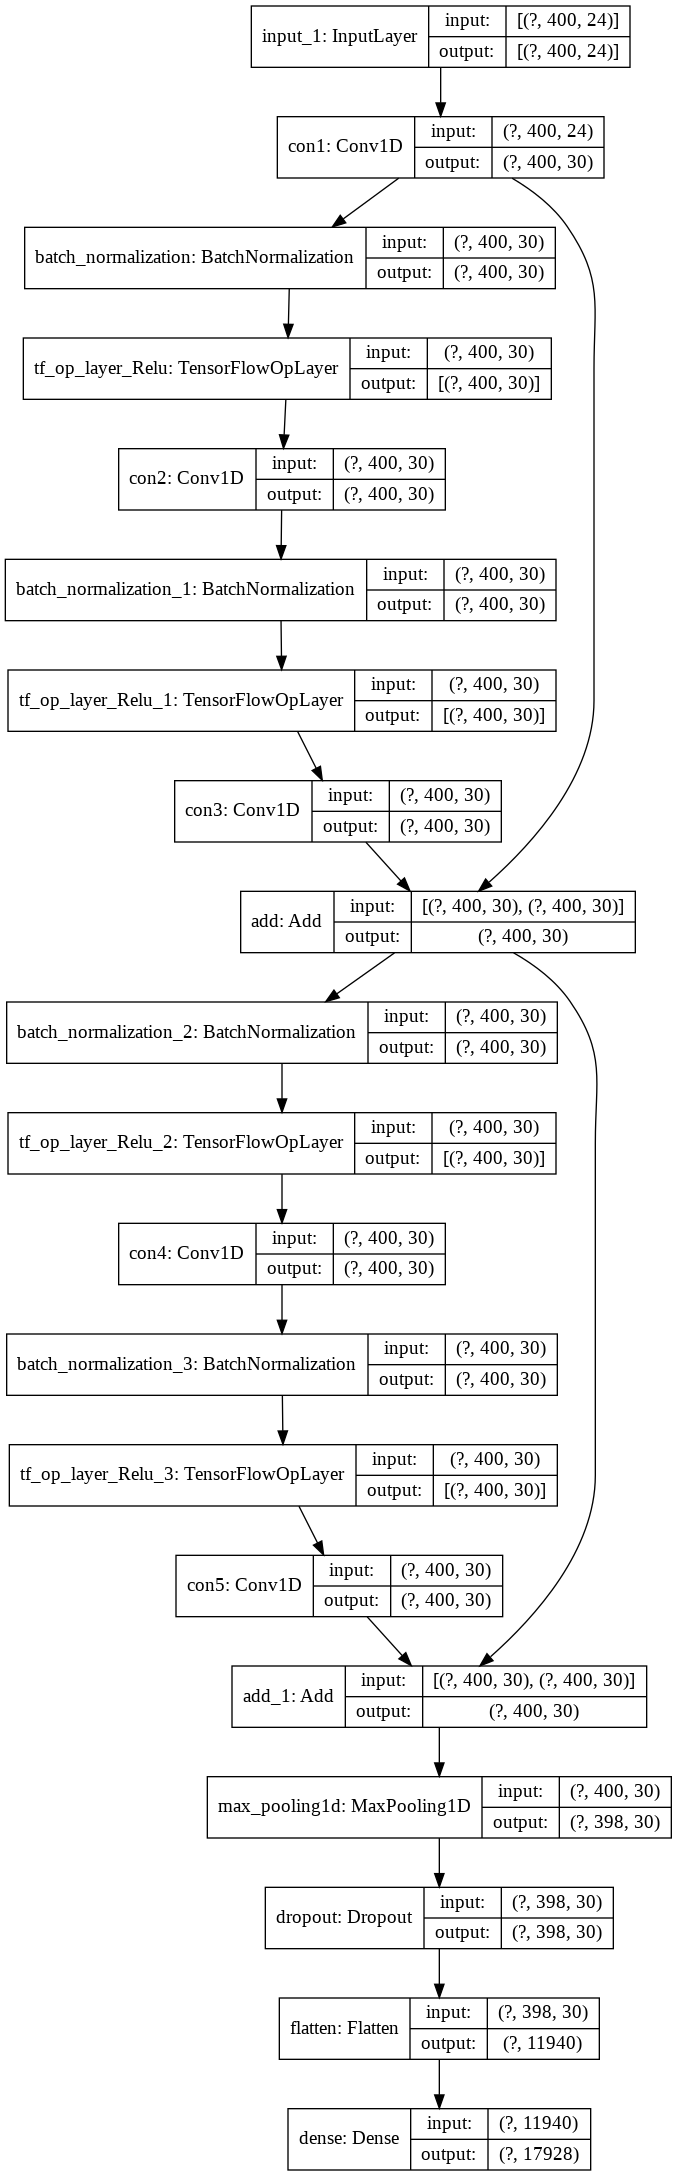

In [ ]:
keras.utils.plot_model(model_30_30_17k, 'model_30_30_17k.png', show_shapes=True)

In [ ]:
################### Train model with 25 batches of each train_generator and validation_data ################### 
# medium.com/coinmonks/word-level-lstm-text-generator-creating-automatic-song-lyrics-with-neural-networks-b8a1617104fb
batch_size = 100
nb_epoch = 50

history_30_30_17k=model_30_30_17k.fit_generator(train_generator_17k,steps_per_epoch=len(train_17k_num)//batch_size,
                validation_data=validation_generator_17k,epochs=nb_epoch,validation_steps=len(test_17k_num)//batch_size)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
10867/10867 [==============================] - 312s 29ms/step - loss: 3.0402 - accuracy: 0.6577 - val_loss: 0.8938 - val_accuracy: 0.8778
Epoch 2/50
10867/10867 [==============================] - 314s 29ms/step - loss: 1.3089 - accuracy: 0.8278 - val_loss: 0.5793 - val_accuracy: 0.9139
Epoch 3/50
10867/10867 [==============================] - 315s 29ms/step - loss: 1.0582 - accuracy: 0.8535 - val_loss: 0.4841 - val_accuracy: 0.9284
Epoch 4/50
10867/10867 [==============================] - 316s 29ms/step - loss: 0.9204 - accuracy: 0.8698 - val_loss: 0.4441 - val_accuracy: 0.9318
Epoch 5/50
10867/10867 [==============================] - 317s 29ms/step - loss: 0.4273 - accuracy: 0.9248 - val_loss: 0.4651 - val_accuracy: 0.9300
Epoch 6/50
10867/10867 [==============================] - 316s 29ms/step - loss: 0.3942 - accuracy: 0.9275 - val_loss: 0.4690 - val_accuracy: 0.9306
Epoch 7/50
10867/10867 [======

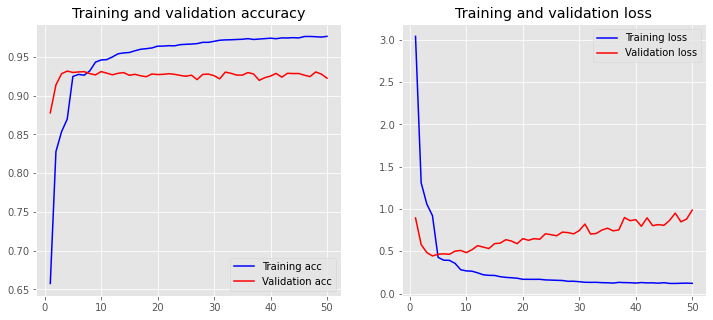

In [ ]:
plot_history(history_30_30_17k)

In [ ]:
# To save and load a Keras model
# https://www.tensorflow.org/guide/keras/save_and_serialize
# https://stackoverflow.com/a/47266538

model_30_30_17k.save('drive/My Drive/Colab Notebooks/model_30_30_17k_class')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: drive/My Drive/Colab Notebooks/model_30_30_17k_class/assets


## Model No. II

In [ ]:
############# Below code will give CNN model with 1000 classes having 550 padding size #############
##https://pylessons.com/Keras-ResNet-tutorial/
##https://www.tensorflow.org/guide/keras/functional
##https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D
x_input = tf.keras.Input(shape=(550,24))
#initial conv (main path)
conv = tf.keras.layers.Conv1D(30, 1, padding='same', name = 'con1')(x_input) 
# (30 convolution kernel of size 1 X 1, input is x_input, output = conv1, padding same i.e. input and output size same.)
## start of 1st stage residual_block1_30_30
shortcut1 = conv
bn1 = tf.keras.layers.BatchNormalization()(conv)
act1 = tf.keras.activations.relu(bn1)
conv1 = tf.keras.layers.Conv1D(30, 1, dilation_rate= 1, padding='same', name = 'con2')(act1) 
# (30 convolution kernel of size 1 X 1, input is act1 i.e. activation relu, output = conv1, padding same i.e. input and
# output size same. Dilation_rate means spacing between the values in a kernel)
#bottleneck convolution
bn2 = tf.keras.layers.BatchNormalization()(conv1)
act2 = tf.keras.activations.relu(bn2)
conv2 = tf.keras.layers.Conv1D(30, 1, padding='same', name = 'con3' )(act2) 
#skip connection
x = tf.keras.layers.Add()([conv2, shortcut1]) # (Add output of bottleneck of 1st stage and initial of main path) 
## end of 1st residual_block_30_30
## start of 2nd residual_block1_30_30
shortcut2 = x
bn1 = tf.keras.layers.BatchNormalization()(x)
act1 = tf.keras.activations.relu(bn1)
conv1 = tf.keras.layers.Conv1D(30, 1, dilation_rate= 1, padding='same', name = 'con4')(act1)
#bottleneck convolution
bn2 = tf.keras.layers.BatchNormalization()(conv1)
act2 = tf.keras.activations.relu(bn2)
conv2 = tf.keras.layers.Conv1D(30, 1, padding='same' , name = 'con5')(act2) 
#skip connection
x1 = tf.keras.layers.Add()([conv2, shortcut2]) # (Add output of bottleneck of 2nd stage and output of 1st stage )
## end of 2nd stage residual_block_30_30
# main path continues and pass it through a maxpool, dropout, dense with a softmax 
x = tf.keras.layers.MaxPooling1D(pool_size=3,strides=1, padding='valid')(x1) 
# (Downsamples the input with max pooling window 3)
x = tf.keras.layers.Dropout(0.5)(x) # Dropout Rate of 0.5
# softmax classifier
x = tf.keras.layers.Flatten()(x)
x_output = tf.keras.layers.Dense(1000,activation='softmax')(x) # (1000 relu neuron , activation='softmax'1)
model_30_30_1k_pad550 = tf.keras.Model(inputs=x_input, outputs=x_output)
model_30_30_1k_pad550.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# (crossentropy loss between the labels and predictions as labels are in a one_hot representation)
model_30_30_1k_pad550.summary()


Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 550, 24)]    0                                            
__________________________________________________________________________________________________
con1 (Conv1D)                   (None, 550, 30)      750         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 550, 30)      120         con1[0][0]                       
__________________________________________________________________________________________________
tf_op_layer_Relu_4 (TensorFlowO [(None, 550, 30)]    0           batch_normalization_4[0][0]      
_______________________________________________________________________________________

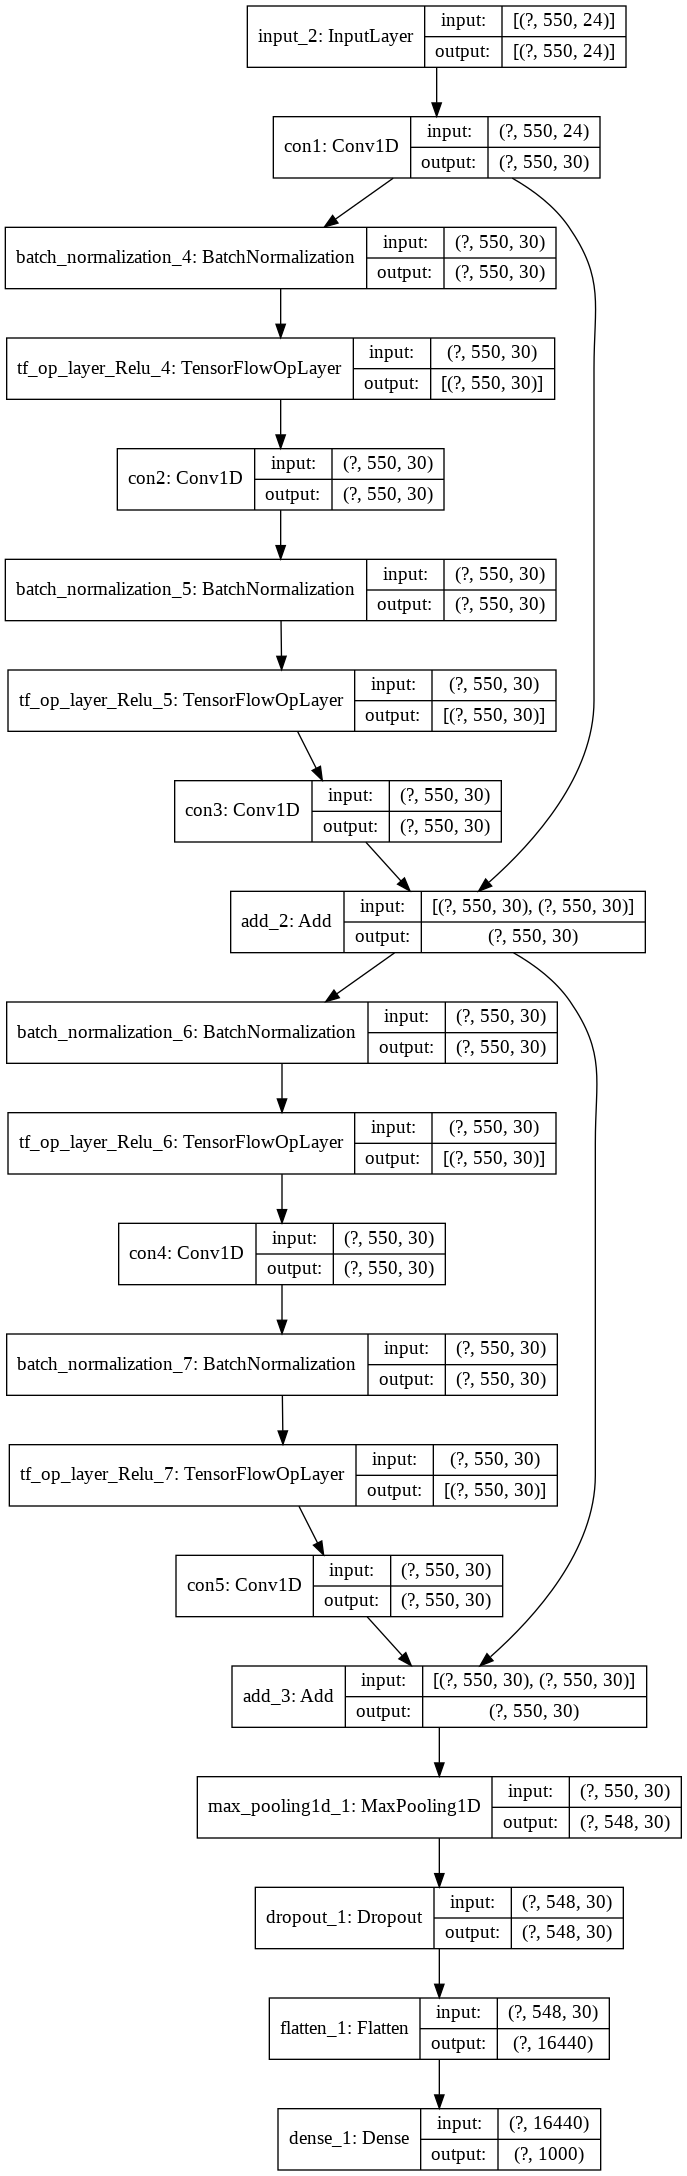

In [ ]:
keras.utils.plot_model(model_30_30_1k_pad550, 'model_30_30_1k_pad550.png', show_shapes=True)

In [ ]:
################### Train model with 1000 batches of each train_generator and validation_data ########
# Train model
batch_size = 1000
nb_epoch = 60
train_steps = len(train_1k_num)//batch_size
test_steps = len(test_1k_num)//batch_size

history_30_30_1k_pad550 = model_30_30_1k_pad550.fit(train_generator_1k,steps_per_epoch = train_steps, 
                                                    validation_data = validation_generator_1k,
                                              epochs = nb_epoch,validation_steps = test_steps)

Epoch 1/60
439/439 [==============================] - 49s 112ms/step - loss: 0.1170 - accuracy: 0.9743 - val_loss: 0.0542 - val_accuracy: 0.9875
Epoch 2/60
439/439 [==============================] - 49s 111ms/step - loss: 0.0287 - accuracy: 0.9924 - val_loss: 0.0528 - val_accuracy: 0.9889
Epoch 3/60
439/439 [==============================] - 49s 111ms/step - loss: 0.0203 - accuracy: 0.9942 - val_loss: 0.0566 - val_accuracy: 0.9888
Epoch 4/60
439/439 [==============================] - 49s 111ms/step - loss: 0.0228 - accuracy: 0.9936 - val_loss: 0.0655 - val_accuracy: 0.9883
Epoch 5/60
439/439 [==============================] - 48s 110ms/step - loss: 0.0231 - accuracy: 0.9936 - val_loss: 0.0702 - val_accuracy: 0.9877
Epoch 6/60
439/439 [==============================] - 48s 110ms/step - loss: 0.0227 - accuracy: 0.9939 - val_loss: 0.0649 - val_accuracy: 0.9894
Epoch 7/60
439/439 [==============================] - 45s 103ms/step - loss: 0.0187 - accuracy: 0.9948 - val_loss: 0.0662 - val_ac

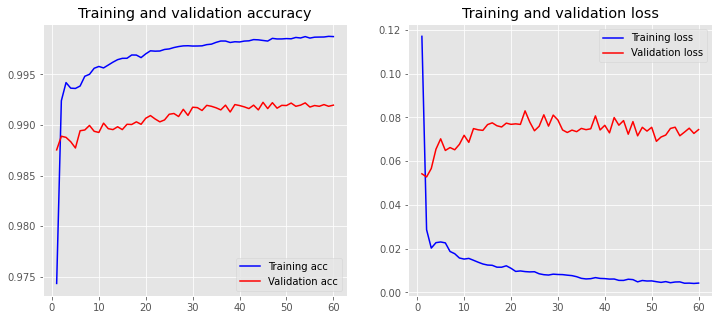

In [ ]:
plot_history(history_30_30_1k_pad550)

In [ ]:

model_30_30_1k_pad550.save('drive/My Drive/Colab Notebooks/model_30_30_1k_class_pad550')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: drive/My Drive/Colab Notebooks/model_30_30_1k_class_pad550/assets


# Bidirectional LSTM

## Model No. III

In [ ]:
# Double Bidirectional LSTM with 64 plus 64 LSTM unit having L2 regularizer (0.0001) & 
# 17928 classes with 400 padding size
# https://www.tensorflow.org/api_docs/python/tf/compat/v1/keras/layers/CuDNNLSTM
model_BiLSTM2L2_17k = tf.keras.Sequential()

model_BiLSTM2L2_17k.add(tf.keras.layers.Bidirectional
                        (tf.compat.v1.keras.layers.CuDNNLSTM
                         (64, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.0001), 
                          recurrent_regularizer=tf.keras.regularizers.l2(0.0001), 
                          bias_regularizer=tf.keras.regularizers.l2(0.0001))))
model_BiLSTM2L2_17k.add(tf.keras.layers.Dropout(0.2))
model_BiLSTM2L2_17k.add(tf.keras.layers.Bidirectional
                        (tf.compat.v1.keras.layers.CuDNNLSTM
                         (64,kernel_regularizer=tf.keras.regularizers.l2(0.0001), 
                          recurrent_regularizer=tf.keras.regularizers.l2(0.0001), 
                          bias_regularizer=tf.keras.regularizers.l2(0.0001))))
model_BiLSTM2L2_17k.add(tf.keras.layers.Dropout(0.1))

# use ReLU in place of tanh function since they are very good alternatives of each other.
model_BiLSTM2L2_17k.add(tf.keras.layers.Dense(17928, activation='relu'))
# When we have multiple outputs, softmax convert outputs layers into a probability distribution.
model_BiLSTM2L2_17k.add(tf.keras.layers.Dense(17928, activation='softmax'))
model_BiLSTM2L2_17k.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_BiLSTM2L2_17k.build(input_shape = (26,400,24))
model_BiLSTM2L2_17k.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (26, 400, 128)            46080     
_________________________________________________________________
dropout_4 (Dropout)          (26, 400, 128)            0         
_________________________________________________________________
bidirectional_3 (Bidirection (26, 128)                 99328     
_________________________________________________________________
dropout_5 (Dropout)          (26, 128)                 0         
_________________________________________________________________
dense_4 (Dense)              (26, 17928)               2312712   
_________________________________________________________________
dense_5 (Dense)              (26, 17928)               321431112 
Total params: 323,889,232
Trainable params: 323,889,232
Non-trainable params: 0
________________________________________

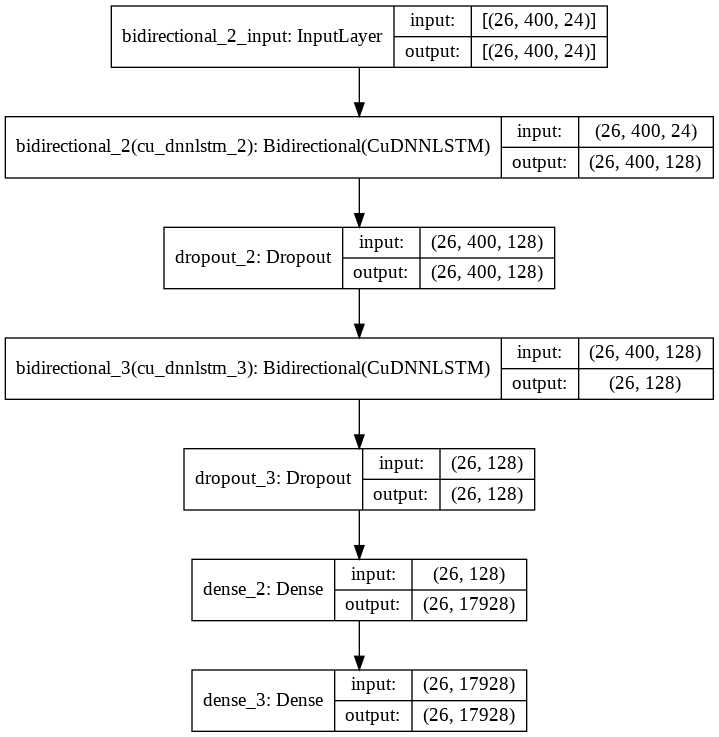

In [ ]:
keras.utils.plot_model(model_BiLSTM2L2_17k, 'model_BiLSTM2L2_17k.png', show_shapes=True)

In [ ]:
 # Train model
batch_size = 100
nb_epoch = 50
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1)
# 'EarlyStopping' stops training when a monitored metric has stopped improving.
history_BiLSTM2L2_17k = model_BiLSTM2L2_17k.fit_generator 
                        (train_generator_17k,steps_per_epoch=len(train_17k_num)//batch_size,
                         validation_data=validation_generator_17k,epochs=nb_epoch,
                         validation_steps = len(dev_17k_num)//batch_size,callbacks=[es])

Epoch 1/50
10867/10867 [==============================] - 1094s 101ms/step - loss: 0.5272 - accuracy: 0.9069 - val_loss: 0.6169 - val_accuracy: 0.9021
Epoch 2/50
10867/10867 [==============================] - 1097s 101ms/step - loss: 0.4760 - accuracy: 0.9184 - val_loss: 0.7863 - val_accuracy: 0.8744
Epoch 3/50
10867/10867 [==============================] - 1094s 101ms/step - loss: 0.4422 - accuracy: 0.9252 - val_loss: 0.7117 - val_accuracy: 0.8871
Epoch 4/50
10867/10867 [==============================] - 1097s 101ms/step - loss: 0.4474 - accuracy: 0.9238 - val_loss: 0.6533 - val_accuracy: 0.9024
Epoch 00004: early stopping


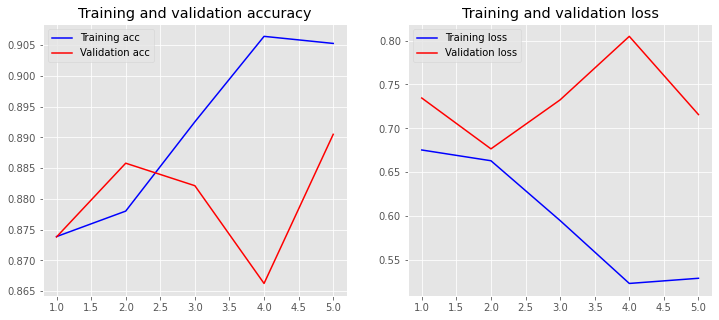

In [ ]:
plot_history(history_BiLSTM2L2_17k)

In [ ]:
model_BiLSTM2L2_17k.save('drive/My Drive/Colab Notebooks/model_BiLSTM2L2_17k')

## Model No. IV

In [ ]:
###### Double Bidirectional LSTM with first top 1000 classes having 64 plus 64 LSTM unit followed by 
###### l2 regularizer (0.0001) with 550 padding size
# https://www.tensorflow.org/api_docs/python/tf/compat/v1/keras/layers/CuDNNLSTM
model_BiLSTM2L2_1k = tf.keras.Sequential()

model_BiLSTM2L2_1k.add(tf.keras.layers.Bidirectional
                       (tf.compat.v1.keras.layers.CuDNNLSTM
                        (64, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.0001), 
                         recurrent_regularizer=tf.keras.regularizers.l2(0.0001), 
                         bias_regularizer=tf.keras.regularizers.l2(0.0001))))
model_BiLSTM2L2_1k.add(tf.keras.layers.Dropout(0.2))
model_BiLSTM2L2_1k.add(tf.keras.layers.Bidirectional
                       (tf.compat.v1.keras.layers.CuDNNLSTM
                        (64,kernel_regularizer=tf.keras.regularizers.l2(0.0001),
                         recurrent_regularizer=tf.keras.regularizers.l2(0.0001), 
                         bias_regularizer=tf.keras.regularizers.l2(0.0001))))
model_BiLSTM2L2_1k.add(tf.keras.layers.Dropout(0.1))

# use ReLU in place of tanh function since they are very good alternatives of each other.
model_BiLSTM2L2_1k.add(tf.keras.layers.Dense(1000, activation='relu'))
# When we have multiple outputs, softmax convert outputs layers into a probability distribution.
model_BiLSTM2L2_1k.add(tf.keras.layers.Dense(1000, activation='softmax'))## 1st 1000 classes 
model_BiLSTM2L2_1k.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_BiLSTM2L2_1k.build(input_shape = (1000, 550, 24))
model_BiLSTM2L2_1k.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (1000, 550, 128)          46080     
_________________________________________________________________
dropout (Dropout)            (1000, 550, 128)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (1000, 128)               99328     
_________________________________________________________________
dropout_1 (Dropout)          (1000, 128)               0         
_________________________________________________________________
dense (Dense)                (1000, 1000)              129000    
_________________________________________________________________
dense_1 (Dense)              (1000, 1000)              1001000   
Total params: 1,275,408
Trainable params: 1,275,408
Non-trainable params: 0
______________________________________________

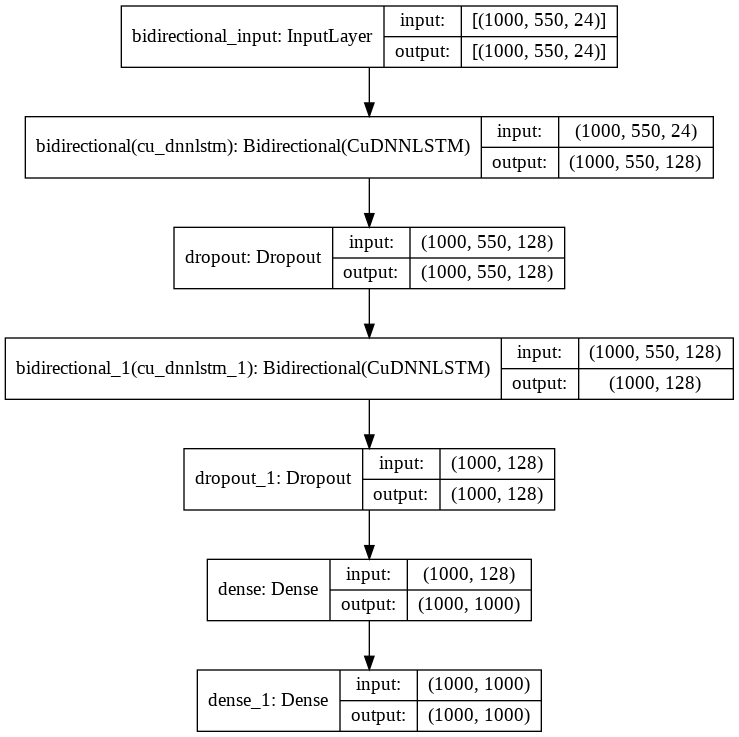

In [ ]:
keras.utils.plot_model(model_BiLSTM2L2_1k, 'model_BiLSTM2L2_1k.png', show_shapes=True)

In [ ]:
# Train model

batch_size = 1000
nb_epoch = 60
train_steps = len(train_1k_num)//batch_size
test_steps = len(test_1k_num)//batch_size

history_BiLSTM2L2_1k_padd550=model_BiLSTM2L2_1k.fit
                            (train_generator_1k,steps_per_epoch=train_steps,validation_data=validation_generator_1k,
                                                                 epochs=nb_epoch,validation_steps = test_steps)

Epoch 1/60
439/439 [==============================] - 138s 314ms/step - loss: 3.8359 - accuracy: 0.2242 - val_loss: 2.0715 - val_accuracy: 0.4931
Epoch 2/60
439/439 [==============================] - 137s 313ms/step - loss: 1.6172 - accuracy: 0.5948 - val_loss: 1.0827 - val_accuracy: 0.7338
Epoch 3/60
439/439 [==============================] - 137s 312ms/step - loss: 1.0117 - accuracy: 0.7462 - val_loss: 0.7394 - val_accuracy: 0.8196
Epoch 4/60
439/439 [==============================] - 137s 311ms/step - loss: 0.7272 - accuracy: 0.8203 - val_loss: 0.5319 - val_accuracy: 0.8765
Epoch 5/60
439/439 [==============================] - 137s 312ms/step - loss: 0.5756 - accuracy: 0.8597 - val_loss: 0.4314 - val_accuracy: 0.9016
Epoch 6/60
439/439 [==============================] - 137s 311ms/step - loss: 0.4738 - accuracy: 0.8871 - val_loss: 0.3640 - val_accuracy: 0.9201
Epoch 7/60
439/439 [==============================] - 136s 310ms/step - loss: 0.4088 - accuracy: 0.9042 - val_loss: 0.3145 -

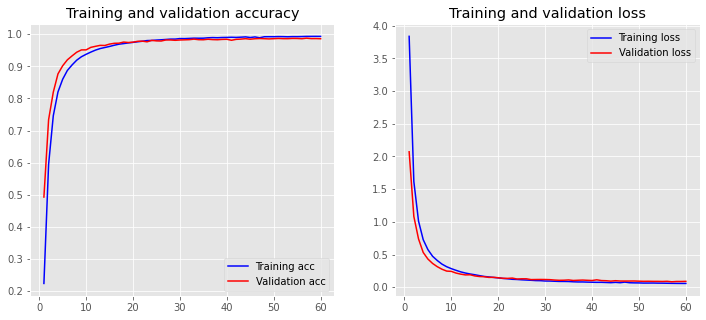

In [ ]:
plot_history(history_BiLSTM2L2_1k_padd550)

In [ ]:
model_BiLSTM2L2_1k.save('drive/My Drive/Colab Notebooks/model_BiLSTM2L2_1k')

# Obsevation

<table style="width: 686px; margin-left: auto; margin-right: auto;">
<tbody>
<tr>
<td style="width: 54.9px;">
<p><strong>Model</strong></p>
<p style="text-align: justify;"><strong>No.</strong></p>
</td>
<td style="width: 54.9px; text-align: justify;">
<p><strong>C</strong><strong>NN Model</strong></p>
<p><strong>Res Block No</strong></p>
</td>
<td style="width: 50.95px; text-align: justify;">
<p><strong>Conv Kernel</strong></p>
</td>
<td style="width: 53px; text-align: justify;">
<p><strong>Padding length</strong></p>
</td>
<td style="width: 50.8833px; text-align: justify;">
<p><strong>Class</strong></p>
</td>
<td style="width: 52.9833px; text-align: justify;">
<p><strong>Dilation rate</strong></p>
</td>
<td style="width: 54.9833px; text-align: justify;">
<p><strong>Dropout</strong></p>
</td>
<td style="width: 52.9px; text-align: justify;">
<p><strong>Loss</strong></p>
</td>
<td style="width: 60.5px; text-align: justify;">
<p><strong>Accuracy</strong></p>
</td>
<td style="width: 65px; text-align: justify;">
<p><strong>Validation</strong></p>
<p><strong>Loss</strong></p>
</td>
<td style="width: 65px; text-align: justify;">
<p><strong>Validation</strong></p>
<p><strong>Accuracy</strong></p>
</td>
</tr>
<tr style="text-align: justify;">
<td style="width: 54.9px;">
<p>I</p>
</td>
<td style="width: 54.9px;">
<p>2</p>
</td>
<td style="width: 50.95px;">
<p>30</p>
</td>
<td style="width: 53px;">
<p>400</p>
</td>
<td style="width: 50.8833px;">
<p>17928</p>
</td>
<td style="width: 52.9833px;">
<p>1</p>
</td>
<td style="width: 54.9833px;">
<p>0.5</p>
</td>
<td style="width: 52.9px;">
<p>0.1206</p>
</td>
<td style="width: 60.5px;">
<p>0.9766</p>
</td>
<td style="width: 65px;">
<p>0.9859</p>
</td>
<td style="width: 65px;">
<p>0.9226</p>
</td>
</tr>
<tr style="text-align: justify;">
<td style="width: 54.9px;">
<p>II</p>
</td>
<td style="width: 54.9px;">
<p>2</p>
</td>
<td style="width: 50.95px;">
<p>30</p>
</td>
<td style="width: 53px;">
<p>550</p>
</td>
<td style="width: 50.8833px;">
<p>1000</p>
</td>
<td style="width: 52.9833px;">
<p>1</p>
</td>
<td style="width: 54.9833px;">
<p>0.5</p>
</td>
<td style="width: 52.9px;">
<p>0.0043</p>
</td>
<td style="width: 60.5px;">
<p>0.9978</p>
</td>
<td style="width: 65px;">
<p>0.0744</p>
</td>
<td style="width: 65px;">
<p>0.9920</p>
</td>
</tr>
</tbody>
</table>
<p style="text-align: justify;">&nbsp;</p>
<table>
<tbody>
<tr>
<td width="75">
<p><strong><strong>Model</strong></strong></p>
<p><strong><strong>No.</strong></strong></p>
</td>
<td width="75">
<p><strong><strong>Bidirectional LSTM</strong></strong></p>
</td>
<td width="66">
<p><strong><strong>LSTM Unit</strong></strong></p>
</td>
<td width="50">
<p><strong><strong>Padding length</strong></strong></p>
</td>
<td width="45">
<p><strong><strong>Class</strong></strong></p>
</td>
<td width="51">
<p><strong><strong>Dropout</strong></strong></p>
</td>
<td width="83">
<p><strong><strong>L2 regularizer</strong></strong></p>
</td>
<td width="66">
<p><strong><strong>Loss</strong></strong></p>
</td>
<td width="55">
<p><strong><strong>Accuracy</strong></strong></p>
</td>
<td width="59">
<p><strong><strong>Validation</strong></strong></p>
<p><strong><strong>Loss</strong></strong></p>
</td>
<td width="62">
<p><strong><strong>Validation</strong></strong></p>
<p><strong><strong>Accuracy</strong></strong></p>
</td>
</tr>
<tr>
<td width="75">
<p>III</p>
</td>
<td width="75">
<p>Double</p>
</td>
<td width="66">
<p>64, 64</p>
</td>
<td width="50">
<p>400</p>
</td>
<td width="45">
<p>17928</p>
</td>
<td width="51">
<p>0.2, 0.1</p>
</td>
<td width="83">
<p>0.0001</p>
</td>
<td width="66">
<p>0.4474</p>
</td>
<td width="55">
<p>0.9238</p>
</td>
<td width="59">
<p>0.6533</p>
</td>
<td width="62">
<p style="text-align: left;">0.9024</p>
</td>
</tr>
<tr>
<td width="75">
<p>IV</p>
</td>
<td width="75">
<p>Double</p>
</td>
<td width="66">
<p>64, 64</p>
</td>
<td width="50">
<p>550</p>
</td>
<td width="45">
<p>1000</p>
</td>
<td width="51">
<p>0.2, 0.1</p>
</td>
<td width="83">
<p>0.0001</p>
</td>
<td width="66">
<p>0.0584</p>
</td>
<td width="55">
<p>0.9932</p>
</td>
<td width="59">
<p>0.0904</p>
</td>
<td width="62">
<p>0.9858</p>
</td>
</tr>
</tbody>
</table>
<p style="text-align: justify;">&nbsp;</p>

# Result
In CNN model no. II shows loss of 0.0043 and accuracy of 0.9978 with validation loss & validation accuracy of 0.0744 & 0.9920 respectively.

In double bidirectional LSTM model no. IV shows loss of 0.0584 and accuracy of 0.9932 with validation loss & validation accuracy of 0.0904 & 0.9858 respectively.

Hence model no. II present marginal more accuracy among all models.